This notebook documents the steps involved in finding communities within the rural road network graph.

In [1]:
from sklearn.cluster import spectral_clustering
import config
import osmnx as ox
import networkx as nx
import numpy as np
import route_planning.helpers.route_planning_helper as helper

Load the graph of the Donegal road network which has had weights applied to its edges based on townland populations. 

In [2]:
graph_file = f"{config.graph_graphml_path}/donegal_osm_weights_applied.graphml"
G = ox.load_graphml(graph_file)
len(G.edges)

7195

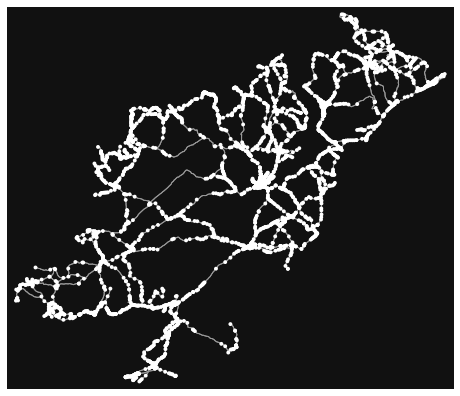

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff9f02d6f70>)

In [3]:
ox.plot_graph(G)

There are some disconnected edges remaining in the bottom right of the graph so these should be removed  before clustering into communities.

For a directed graph a seperate list strongly/weakly connected components can be found.

Remove any set of connected components made up of fewer than 10 elements.

In [4]:
connected_strongly = list(nx.strongly_connected_components(G))
connected_weakly = list(nx.weakly_connected_components(G))

connected_components = connected_strongly + connected_weakly

# get any sets of nodes with less than 10 elements
few_connections = []
for c in connected_components:
    if len(c) < 10:
        few_connections.append(c)
# remove the nodes
for fc in few_connections:
    G.remove_nodes_from(fc)
ox.save_graphml(G, filepath=f"{config.graph_path}/graphml/donegal_osm_weights_applied.graphml")


No disconnected parts remain in the graph

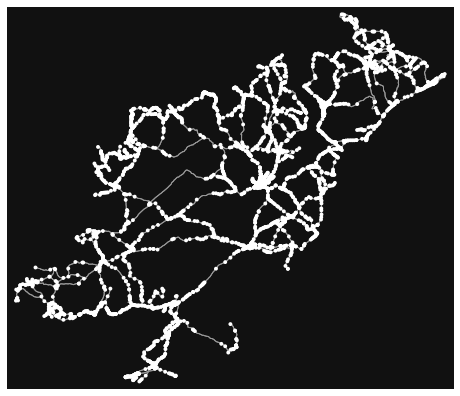

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ff9f01a8910>)

In [5]:
ox.plot_graph(G)

Edge weights are loaded as strings so need to convert to numeric

In [6]:
helper.convert_edge_weights_to_floats(G)

Get the weighted adjacency matrix

In [7]:
A = nx.to_numpy_array(G, weight="weight")
A

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0., 199.],
       [  0.,   0.,   0., ...,   0., 235.,   0.]])

In [8]:
len(A)

3579

Perform spectral clustering using the adjacency matrix. 

Find 18 clusters. 24 routes currently operated in Donegal by LocalLink (https://www.locallink.ie/en/timetables/regular-rural-services/). 

This is done so that a better connected bus network can be created, with 18 community routes and 6 connecting routes between the communities.

In [9]:
%%time
n_clust = 18
sc = spectral_clustering(A, n_clusters=n_clust)
np.save("../clusters/sc.npy", sc)

/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/sklearn/utils/validation.py:73: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  return f(**kwargs)
/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


KeyboardInterrupt: 

In [9]:
sc = np.load("../clusters/sc.npy")

Apply community labels based on cluster assigned to each node during spectral clustering process.

In [10]:
len(sc)

3579

In [11]:
nx.set_node_attributes(G, 0, "community")
i = 0
for node in G.nodes:
    G.nodes[node]["community"] = sc[i]
    i += 1
G.nodes(data=True)

NodeDataView({2907242498: {'y': 54.8652516, 'x': -7.5081556, 'osmid': 2907242498, 'community': 15}, 780664835: {'y': 54.972684, 'x': -7.7090562, 'osmid': 780664835, 'community': 10}, 1908244498: {'y': 54.85721, 'x': -7.5405803, 'osmid': 1908244498, 'community': 15}, 3201138706: {'y': 54.6479035, 'x': -8.6183871, 'osmid': 3201138706, 'community': 4}, 3201138713: {'y': 54.6479279, 'x': -8.6214864, 'osmid': 3201138713, 'community': 4}, 1417674781: {'y': 55.2257747, 'x': -7.0858022, 'osmid': 1417674781, 'community': 1}, 3151921209: {'y': 54.6337503, 'x': -8.6474055, 'osmid': 3151921209, 'community': 4}, 3112960060: {'y': 54.5228223, 'x': -8.1558733, 'osmid': 3112960060, 'community': 17}, 911999040: {'y': 54.7766345, 'x': -8.316315, 'osmid': 911999040, 'community': 5}, 821231682: {'y': 54.9665332, 'x': -7.4597948, 'osmid': 821231682, 'community': 15}, 1908244553: {'y': 54.8561017, 'x': -7.635638, 'osmid': 1908244553, 'community': 2}, 1417674837: {'y': 55.2315345, 'x': -7.084004, 'osmid': 14

Plot the graph with coloured communities.

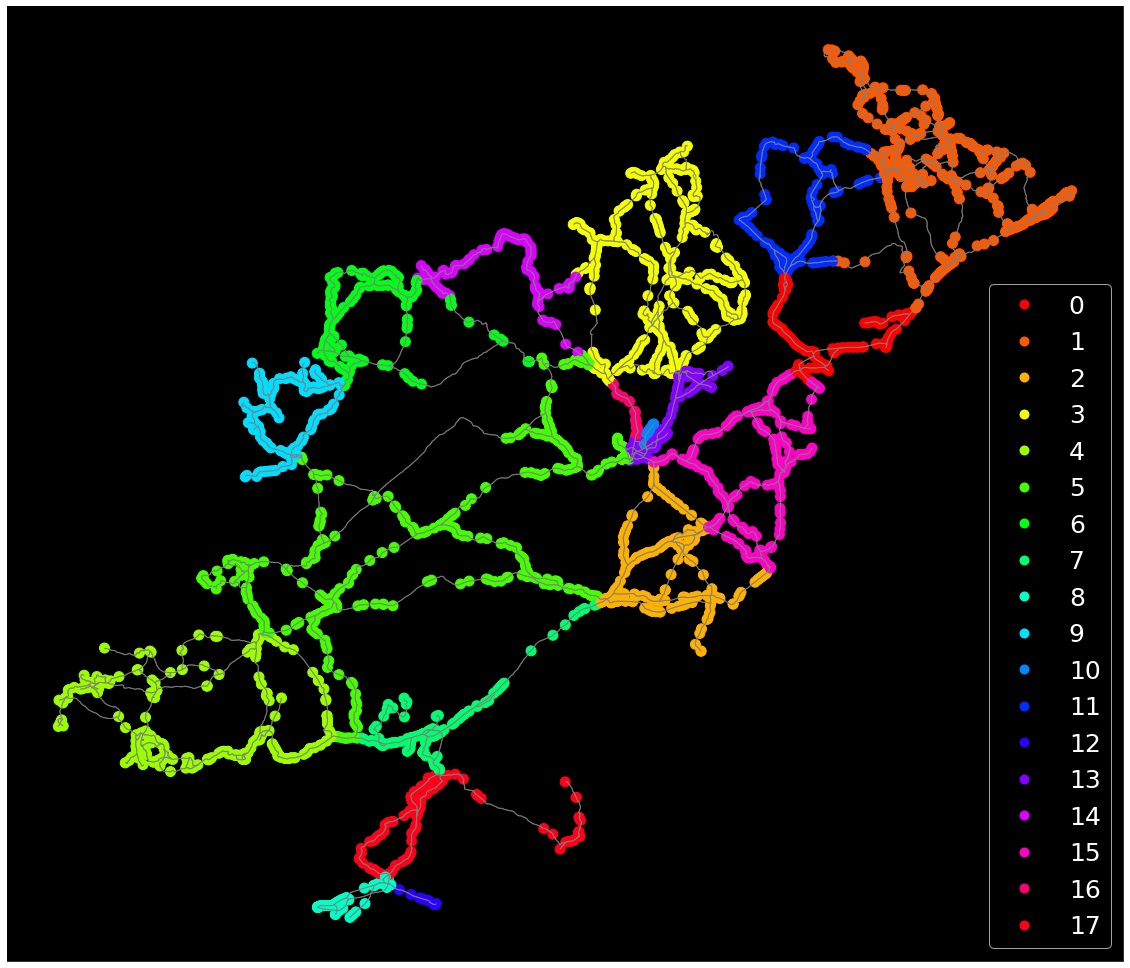

In [12]:
nodes, edges = ox.graph_to_gdfs(G)

helper.plot_community_graph(nodes, edges)

The three southmost communities (8, 12, 17) and those around Letterkenny (10, 13, 16) will be combined.

In [13]:
for node in G.nodes:
    community = G.nodes[node]["community"]
    if community == 8 or community == 12 or community == 17:
        G.nodes[node]["community"] = 8
    if community == 10 or community == 13 or community == 16:
        G.nodes[node]["community"] = 10

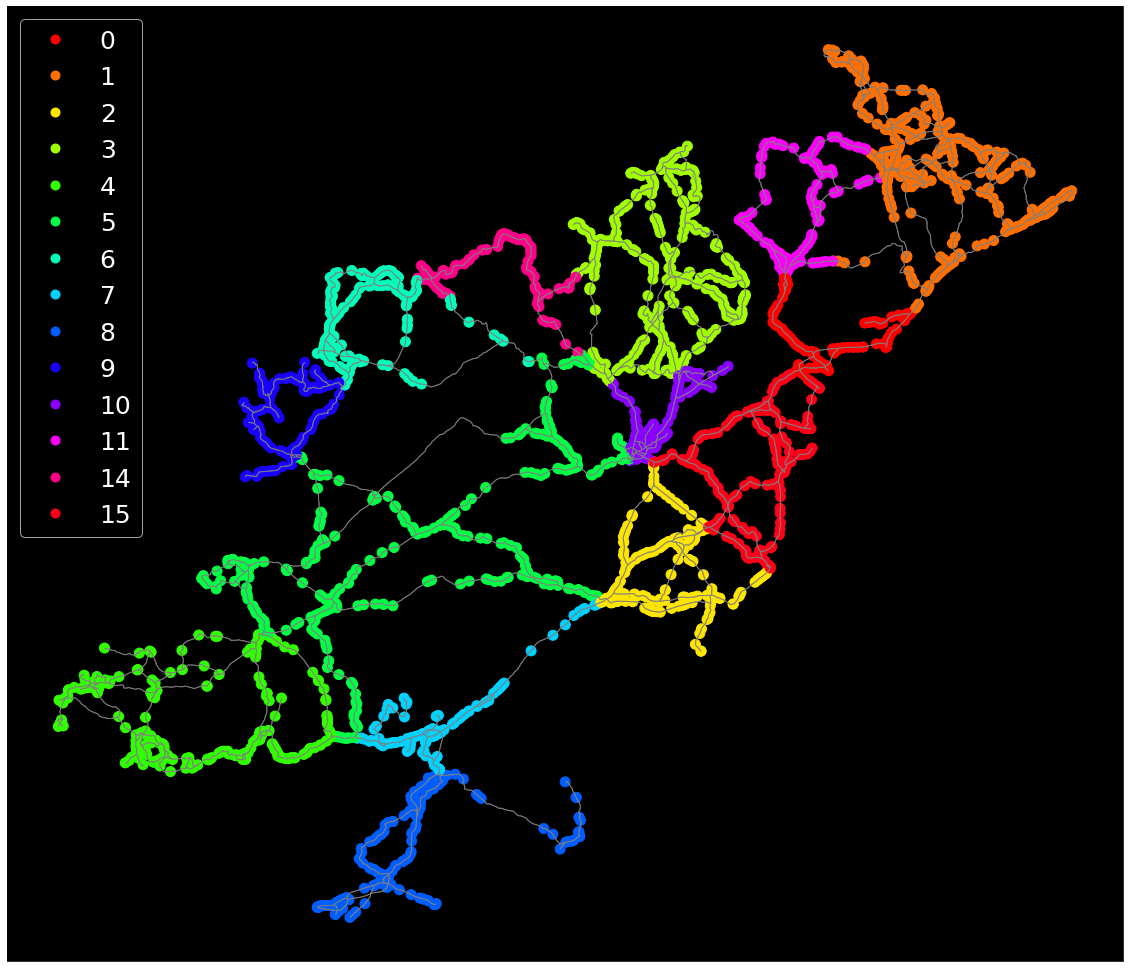

In [14]:
nodes, edges = ox.graph_to_gdfs(G)

helper.plot_community_graph(nodes, edges)

Now we're left with 14 communities to plot routes through.

In [16]:
ox.save_graphml(G, filepath=f"{config.rp_graphml_path}/communities.graphml")